In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
train_dir = "dataset/train"
valid_dir = "dataset/validation"
test_dir = "dataset/test"
num_classes = 36

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,    # [0,255] => [0,1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2, #修剪
    zoom_range=0.2, #缩放
    horizontal_flip=True, #翻转
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

validation_datagen = ImageDataGenerator(
    rescale=1./255
)

In [4]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

validation_generator = validation_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

Found 3115 images belonging to 36 classes.
Found 359 images belonging to 36 classes.
Found 351 images belonging to 36 classes.


In [5]:
# 架构mobilenet预训练模型，基于imagenet的训练数据，不包括输出层参数

from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# 对base模型参数不可调整
for layer in base_model.layers:
    layer.trainable = False

In [6]:
# 定义我们自己的输出层

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

x = base_model.output
x = GlobalAveragePooling2D()(x)  #每个feature map取平均，生成特征向量
x = Dense(1024, activation="relu")(x) #1024全连接层
predictions = Dense(num_classes, activation="softmax")(x) #10分类的概率分布

model = Model(inputs=base_model.input, outputs=predictions)

In [7]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [8]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

 ormalization)                                                                                    
                                                                                                  
 block_2_add (Add)           (None, 56, 56, 24)           0         ['block_1_project_BN[0][0]',  
                                                                     'block_2_project_BN[0][0]']  
                                                                                                  
 block_3_expand (Conv2D)     (None, 56, 56, 144)          3456      ['block_2_add[0][0]']         
                                                                                                  
 block_3_expand_BN (BatchNo  (None, 56, 56, 144)          576       ['block_3_expand[0][0]']      
 rmalization)                                                                                     
                                                                                                  
 block_3_e

In [9]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=100
)

c:\Users\zhfal\anaconda3\envs\dev\Lib\site-packages\PIL\Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/100
97/97 [==============================] - 185s 2s/step - loss: 1.3562 - accuracy: 0.6215 - val_loss: 0.3811 - val_accuracy: 0.8656
Epoch 2/100
97/97 [==============================] - 161s 2s/step - loss: 0.6209 - accuracy: 0.8002 - val_loss: 0.2690 - val_accuracy: 0.9187
Epoch 3/100
97/97 [==============================] - 171s 2s/step - loss: 0.4644 - accuracy: 0.8488 - val_loss: 0.3198 - val_accuracy: 0.9219
Epoch 4/100
97/97 [==============================] - 166s 2s/step - loss: 0.3767 - accuracy: 0.8673 - val_loss: 0.2120 - val_accuracy: 0.9375
Epoch 5/100
97/97 [==============================] - 166s 2s/step - loss: 0.3260 - accuracy: 0.8897 - val_loss: 0.2447 - val_accuracy: 0.9156
Epoch 6/100
97/97 [==============================] - 173s 2s/step - loss: 0.2447 - accuracy: 0.9127 - val_loss: 0.1968 - val_accuracy: 0.9438
Epoch 7/100
97/97 [==============================] - 175s 2s/step - loss: 0.2470 - accuracy: 0.9082 - val_loss: 0.2712 - val_accuracy: 0.9312
Epoch 

In [10]:
history_df = pd.DataFrame(history.history)
history_df

,loss,accuracy,val_loss,val_accuracy
0,1.356205,0.621473,0.381129,0.865625
1,0.620852,0.800195,0.269018,0.918750
2,0.464414,0.848849,0.319813,0.921875
3,0.376690,0.867337,0.212040,0.937500
4,0.326018,0.889718,0.244713,0.915625
...,...,...,...,...
95,0.057981,0.981512,0.210280,0.965625
96,0.044039,0.984755,0.149876,0.968750
97,0.071298,0.979241,0.288352,0.962500
98,0.066774,0.977944,0.205323,0.965625


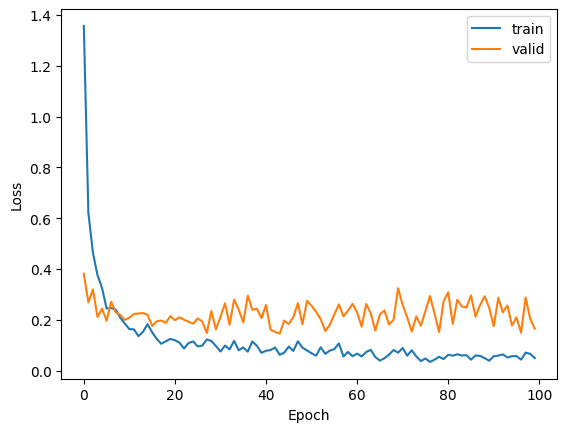

In [11]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "valid"])
plt.show()

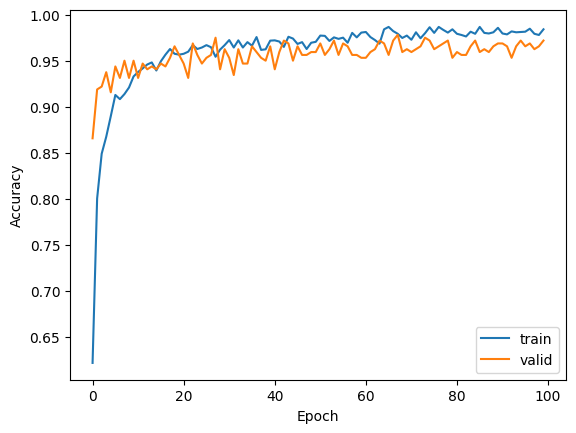

In [12]:
plt.figure()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "valid"])
plt.show()

In [13]:
preds = model.predict(test_generator)

12/12 [==============================] - 24s 2s/step


In [14]:
y_pred = np.argmax(preds, axis=1)

In [15]:
pred_classes = {}
for k, v in test_generator.class_indices.items():
    print(v, ":", k)
    pred_classes[v] = k

pred_classes

0 : apple
1 : banana
2 : beetroot
3 : bell pepper
4 : cabbage
5 : capsicum
6 : carrot
7 : cauliflower
8 : chilli pepper
9 : corn
10 : cucumber
11 : eggplant
12 : garlic
13 : ginger
14 : grapes
15 : jalepeno
16 : kiwi
17 : lemon
18 : lettuce
19 : mango
20 : onion
21 : orange
22 : paprika
23 : pear
24 : peas
25 : pineapple
26 : pomegranate
27 : potato
28 : raddish
29 : soy beans
30 : spinach
31 : sweetcorn
32 : sweetpotato
33 : tomato
34 : turnip
35 : watermelon


{0: 'apple',
 1: 'banana',
 2: 'beetroot',
 3: 'bell pepper',
 4: 'cabbage',
 5: 'capsicum',
 6: 'carrot',
 7: 'cauliflower',
 8: 'chilli pepper',
 9: 'corn',
 10: 'cucumber',
 11: 'eggplant',
 12: 'garlic',
 13: 'ginger',
 14: 'grapes',
 15: 'jalepeno',
 16: 'kiwi',
 17: 'lemon',
 18: 'lettuce',
 19: 'mango',
 20: 'onion',
 21: 'orange',
 22: 'paprika',
 23: 'pear',
 24: 'peas',
 25: 'pineapple',
 26: 'pomegranate',
 27: 'potato',
 28: 'raddish',
 29: 'soy beans',
 30: 'spinach',
 31: 'sweetcorn',
 32: 'sweetpotato',
 33: 'tomato',
 34: 'turnip',
 35: 'watermelon'}

In [16]:
# pred_classes = {
#     0 : "apple",
#     1 : "banana",
#     2 : "grapes",
#     3 : "kiwi",
#     4 : "mango",
#     5 : "orange",
#     6 : "pear",
#     7 : "pineapple",
#     8 : "pomegranate",
#     9 : "watermelon"
# }

In [17]:
y_pred = list(map(lambda x: pred_classes[x], y_pred))

In [18]:
y_test = list(map(lambda x: pred_classes[x], test_generator.classes))

In [19]:
from sklearn.metrics import classification_report

print(classification_report(y_pred, y_test))

               precision    recall  f1-score   support

        apple       0.80      1.00      0.89         8
       banana       0.78      1.00      0.88         7
     beetroot       1.00      1.00      1.00        10
  bell pepper       1.00      0.83      0.91        12
      cabbage       1.00      1.00      1.00        10
     capsicum       0.80      1.00      0.89         8
       carrot       0.90      1.00      0.95         9
  cauliflower       1.00      1.00      1.00        10
chilli pepper       1.00      1.00      1.00        10
         corn       1.00      0.83      0.91        12
     cucumber       1.00      1.00      1.00        10
     eggplant       1.00      1.00      1.00        10
       garlic       1.00      1.00      1.00        10
       ginger       1.00      1.00      1.00        10
       grapes       1.00      1.00      1.00        10
     jalepeno       1.00      0.83      0.91        12
         kiwi       1.00      1.00      1.00        10
        l

In [20]:
model.save("mv2_lr_0.001.h5")

c:\Users\zhfal\anaconda3\envs\dev\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
